# Vertical and Horizontal Integration Tutorial for ST and SM Data

In [1]:
cd ..

/home/rolan/Documents/spatialMETA


/home/rolan/miniconda3/envs/spatialtk/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


This tutorial demonstrates the process of vertically and horizontally integrating aligned and reassigned ST and SM data using spatialMETA. Vertical and horizontal integration is a powerful technique to address modality fusion and batch effects.

In [2]:
import spatialmeta as smt
import numpy as np
import pandas as pd
import scanpy as sc
import torch
import copy
import matplotlib.pyplot as plt

In [3]:
RCC_sample_list = ["R114_T","S15_T","X49_T","Y27_T","Y7_T"]

## Read and preprocess data

### Read and merge data

In this step, we read and merge data. 

In [ ]:
# If data is available
for i in ["R114_T","S15_T","X49_T","Y27_T","Y7_T"]:
    joint_adata = sc.read_h5ad("./adata_joint_"+i+"_raw.h5ad")
    joint_adata_name = "joint_adata_" +i
    globals()[joint_adata_name] = joint_adata

In [ ]:
#Test data can be obtained from SpatialMETA
for i in ["R114_T","S15_T","X49_T","Y27_T","Y7_T"]:
    joint_adata = smt.data.load_adata(
        sample_name= i+"_raw",
        modality="joint"
    )
    joint_adata_name = "joint_adata_" +i
    globals()[joint_adata_name] = joint_adata

In [6]:
merge_adata = anndata.concat({
"R114_T":joint_adata_R114_T,
"S15_T":joint_adata_S15_T,
"X49_T":joint_adata_X49_T,
"Y27_T":joint_adata_Y27_T,
"Y7_T":joint_adata_Y7_T,
},label="sample")

/home/rolan/miniconda3/envs/spatialtk/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [7]:
merge_adata.var = joint_adata_Y7_T.var

In [8]:
merge_adata

AnnData object with n_obs × n_vars = 20038 × 37703
    obs: 'x_coord', 'y_coord', 'spot_name', 'total_intensity', 'mean_intensity', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'sample'
    var: 'name', 'type'
    obsm: 'spatial'

### Normalize merge data

In this step, we normalize the merged data.

In [9]:
merge_adata.layers["counts"] = merge_adata.X.copy()

In [10]:
smt.pp.normalize_total_joint_adata_sm_st(merge_adata,
                         target_sum_SM=1e4,
                         target_sum_ST=1e4)

In [11]:
merge_adata.layers["normalized"] = merge_adata.X.copy()

### Quality control

We perform quality control to remove low-quality spots.

In [13]:
merge_adata = merge_adata[merge_adata.obs['total_intensity']>=1e5]

In [14]:
merge_adata = merge_adata[merge_adata.obs['total_counts']<=40000]

### Calculate SVGs/SVMs and remove batch-baised SVGs/SVMs

We also calculate spatial variable genes/metabolites(SVGs/SVMs) to identify features that exhibit spatial variation. In addition, we remove those that are batch-biased. 

In [16]:
smt.pp.spatial_variable_joint_adata_sm_st(
    merge_adata,
    n_top_genes = 2500,
    n_top_metabolites = 1000,
    batch_key="sample",
    min_samples = 3,
    min_frac = 0.9,
    min_logfc= 3,
)

In [17]:
merge_data = merge_adata[:,merge_adata.var.highly_variable_moranI]

In [18]:
merge_data

View of AnnData object with n_obs × n_vars = 19860 × 2841
    obs: 'x_coord', 'y_coord', 'spot_name', 'total_intensity', 'mean_intensity', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'sample'
    var: 'name', 'type', 'highly_variable_moranI'
    obsm: 'spatial'
    layers: 'counts', 'normalized'

In [19]:
merge_adata.write_h5ad("./spatialmeta_tutorial/data/ccRCC_merge_hvf.h5ad")

## ConditionalVAE for horizontal integration for ST and SM

In this step, we perform horizontal integration using the ConditionalVAE model.

In [20]:
merge_adata.X = merge_adata.layers["counts"]

In [21]:
smt.pp.normalize_total_joint_adata_sm_st(
    merge_adata,
    target_sum_SM=1e3,
    target_sum_ST=None
)

In [22]:
model = smt.model.ConditionalVAESTSM(
    merge_adata,
    n_latent=10,
    device='cuda:0',
    batch_keys= ["sample"],
    batch_embedding="embedding",
    reconstruction_method_sm='g',
    reconstruction_method_st='zinb',
)

In [23]:
loss_dict = model.fit(
    max_epoch=64, 
    lr=1e-3,
    kl_loss_reduction= 'mean',
    mode='multi'
)

/home/rolan/Documents/spatialMETA/spatialmeta/util/logger.py:151: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm as tqdm_notebook
Epoch 64: 100%|██████████| 64/64 [05:15<00:00,  4.93s/it, reconst_sm=-2.29e+03, reconst_st=5.86e+03,


### Loss visualization

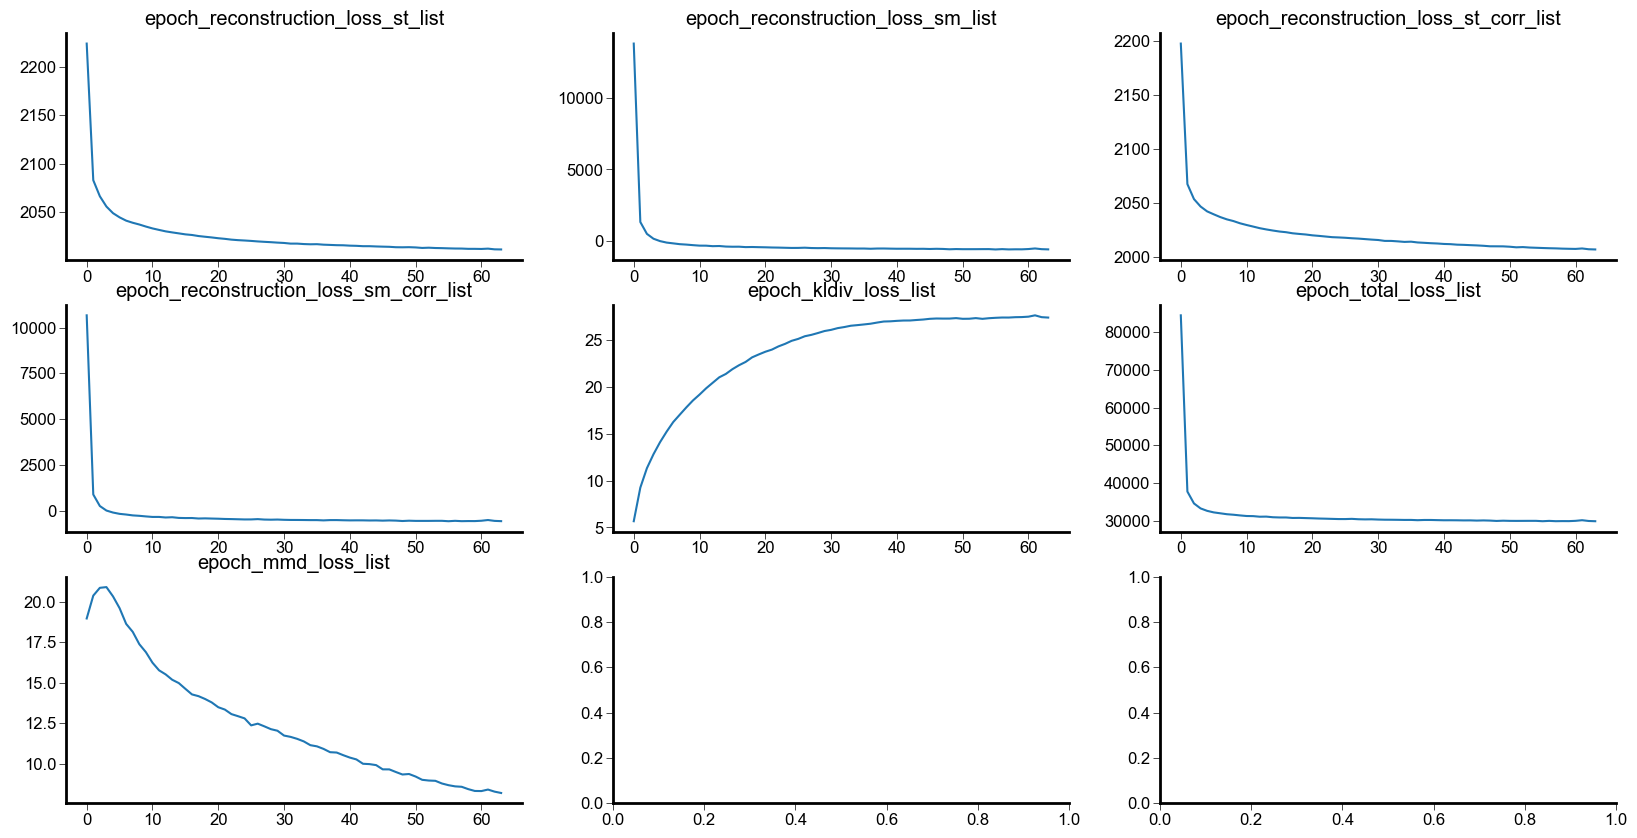

In [32]:
fig,axes=createSubplots(3,3,figsize=(20,10))
axes=axes.flatten()
for ax,(k,v) in zip(axes, loss_dict.items()):
    ax.plot(v)
    ax.set_title(k)

### Visualization and analysis

In [33]:
Z = model.get_latent_embedding()
X = model.get_normalized_expression()
C = model.get_modality_contribution()

Latent Embedding: 100%|██████████| 156/156 [00:00<00:00, 161.32it/s]                                


In [34]:
merge_adata.layers['reconstruction'] = X
merge_adata.obsm['X_emb']=Z
merge_adata.obsm['contribution_st']=Z
merge_adata.obsm['contribution_sm']=1-Z

In [35]:
sc.pp.neighbors(merge_adata,
                use_rep="X_emb",
                n_neighbors=20)

In [36]:
sc.tl.umap(merge_adata,
           min_dist=1,
           spread=1)

In [37]:
sc.tl.leiden(merge_adata, 
             resolution= 1,
             key_added="VAE_clusters_latent10")

<Axes: title={'center': 'sample'}, xlabel='UMAP1', ylabel='UMAP2'>

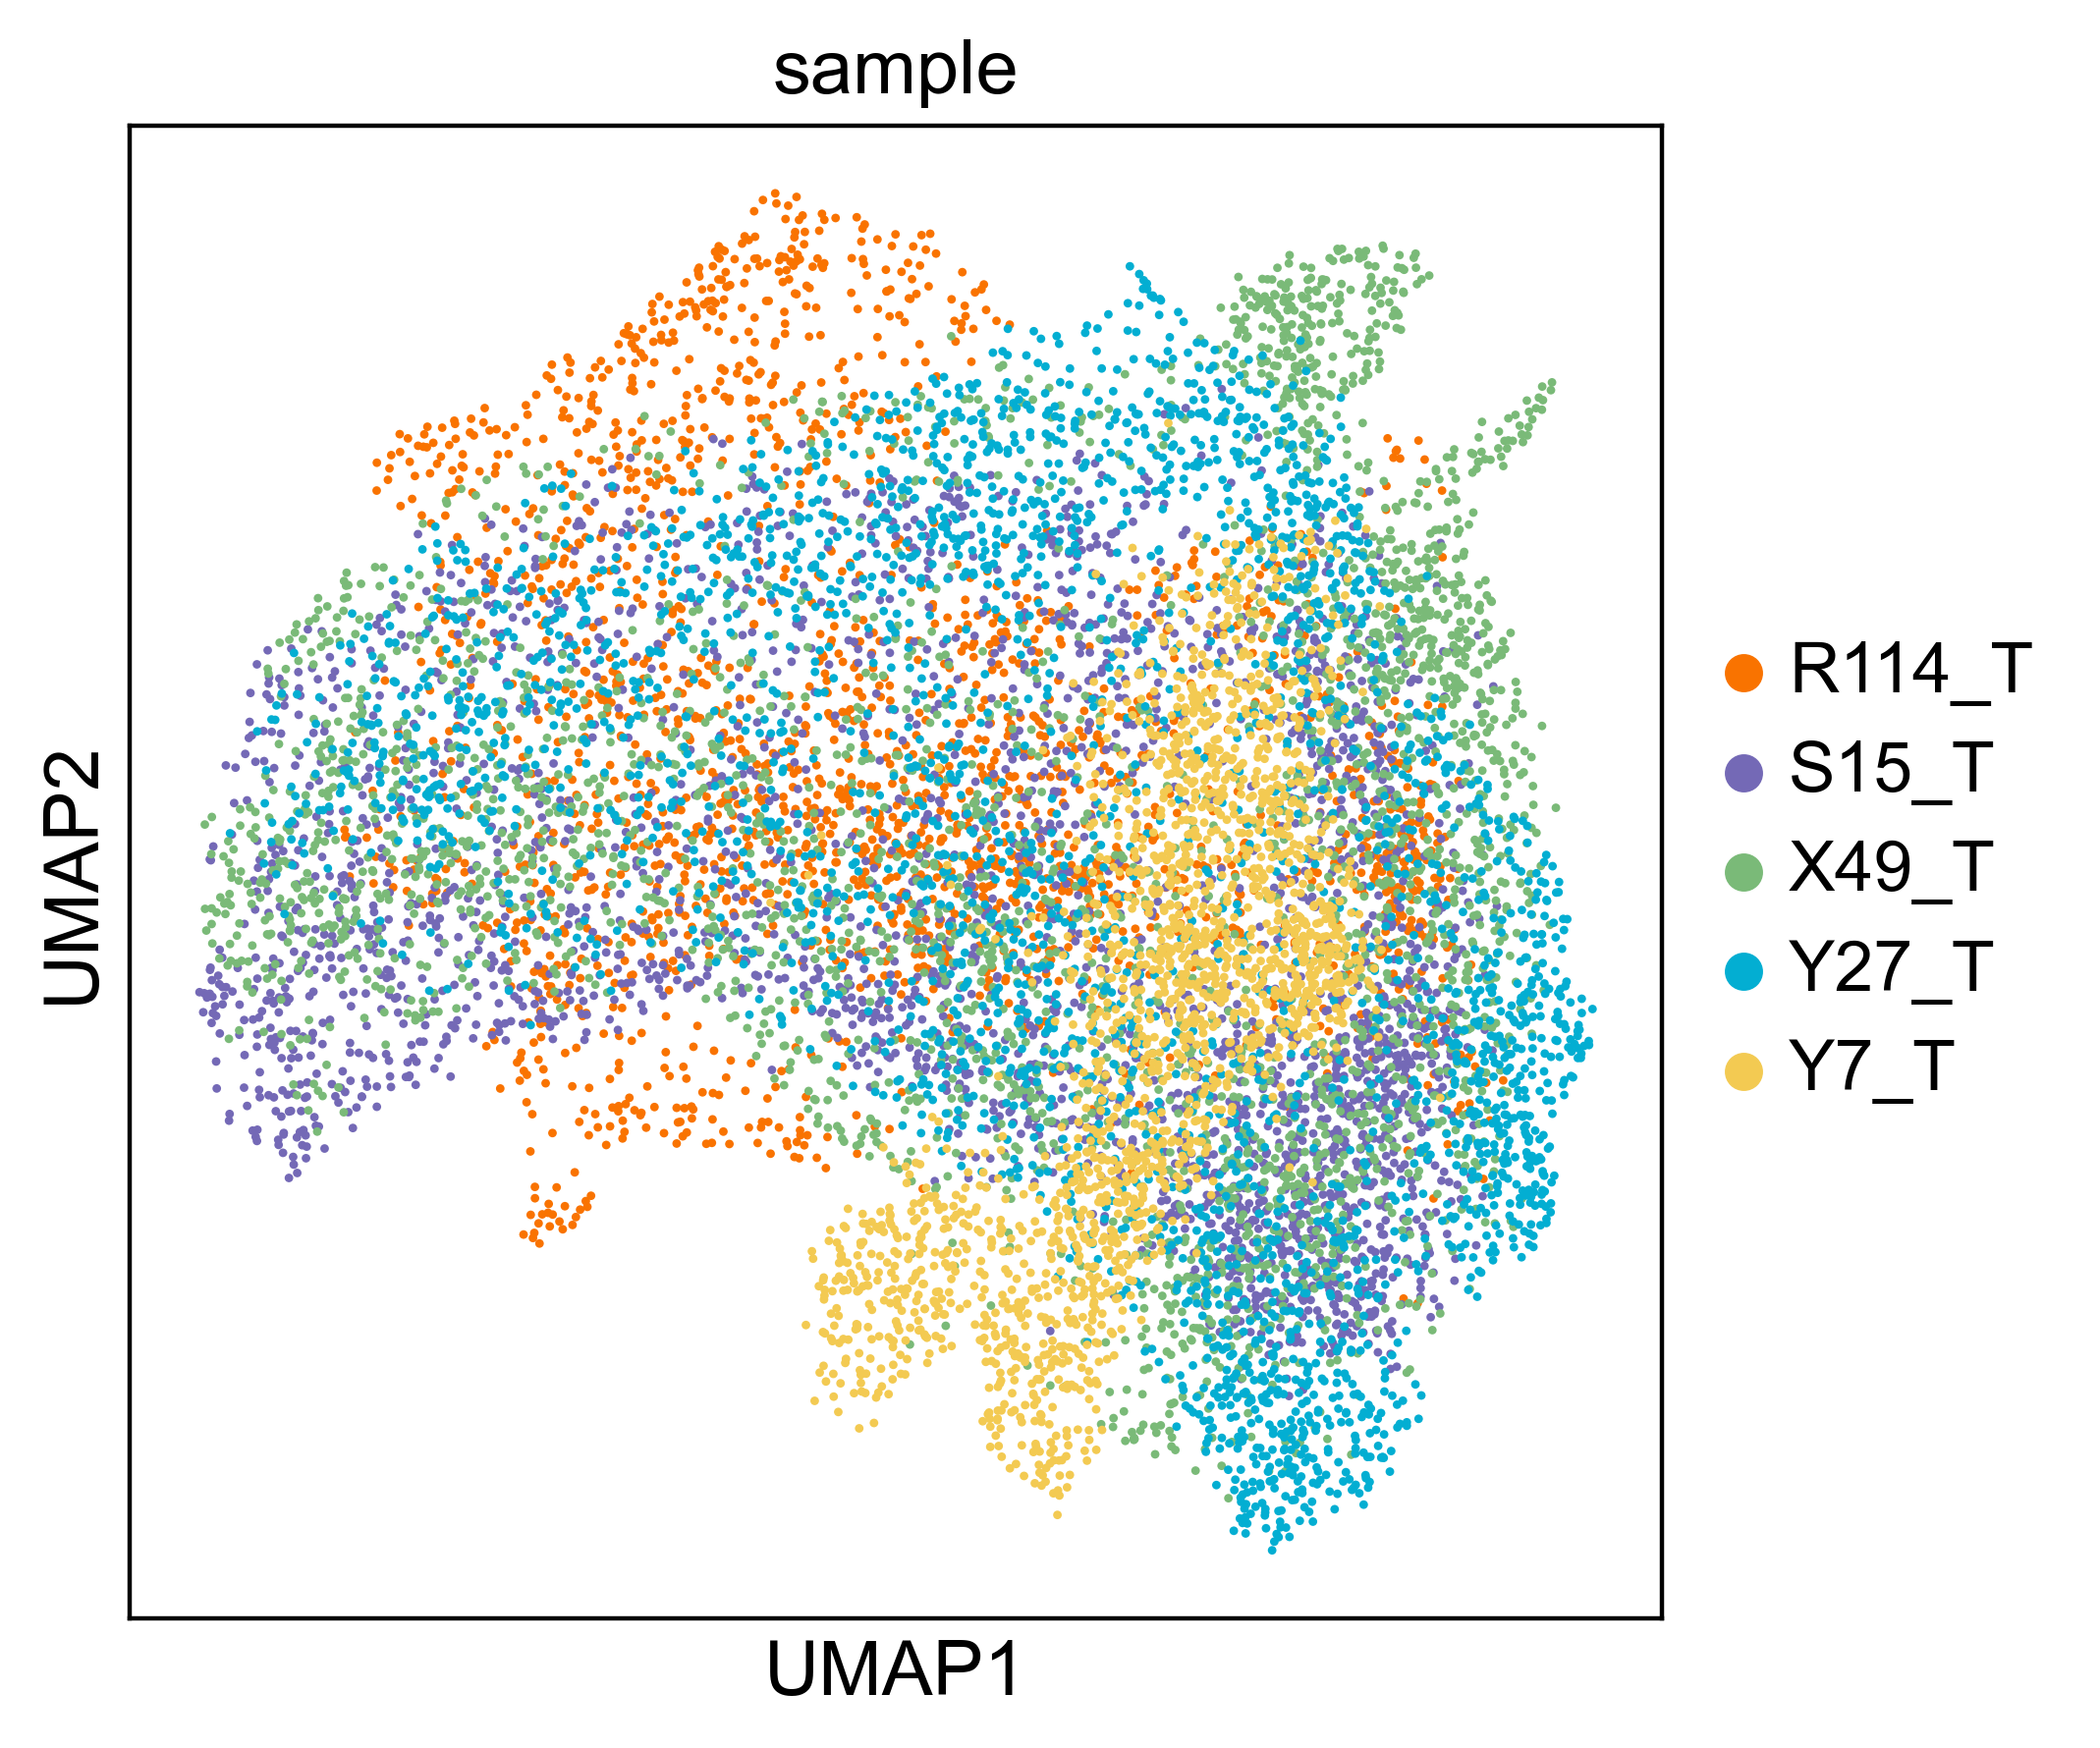

In [40]:
sc.settings.set_figure_params(dpi=200, facecolor="white")
fig,ax=plt.subplots()
fig.set_size_inches(5,5)
sc.pl.umap(merge_adata,
           color=["sample"],
           palette = {
              "R114_T": "#F97300",
              "S15_T": "#7469B6",
              "X49_T": "#7ABA78",
              "Y27_T": "#03AED2",
              "Y7_T": "#F3CA52",
           },
           show = False,
           size = 10,
           ax=ax
)

<Axes: title={'center': 'VAE_clusters_latent10'}, xlabel='UMAP1', ylabel='UMAP2'>

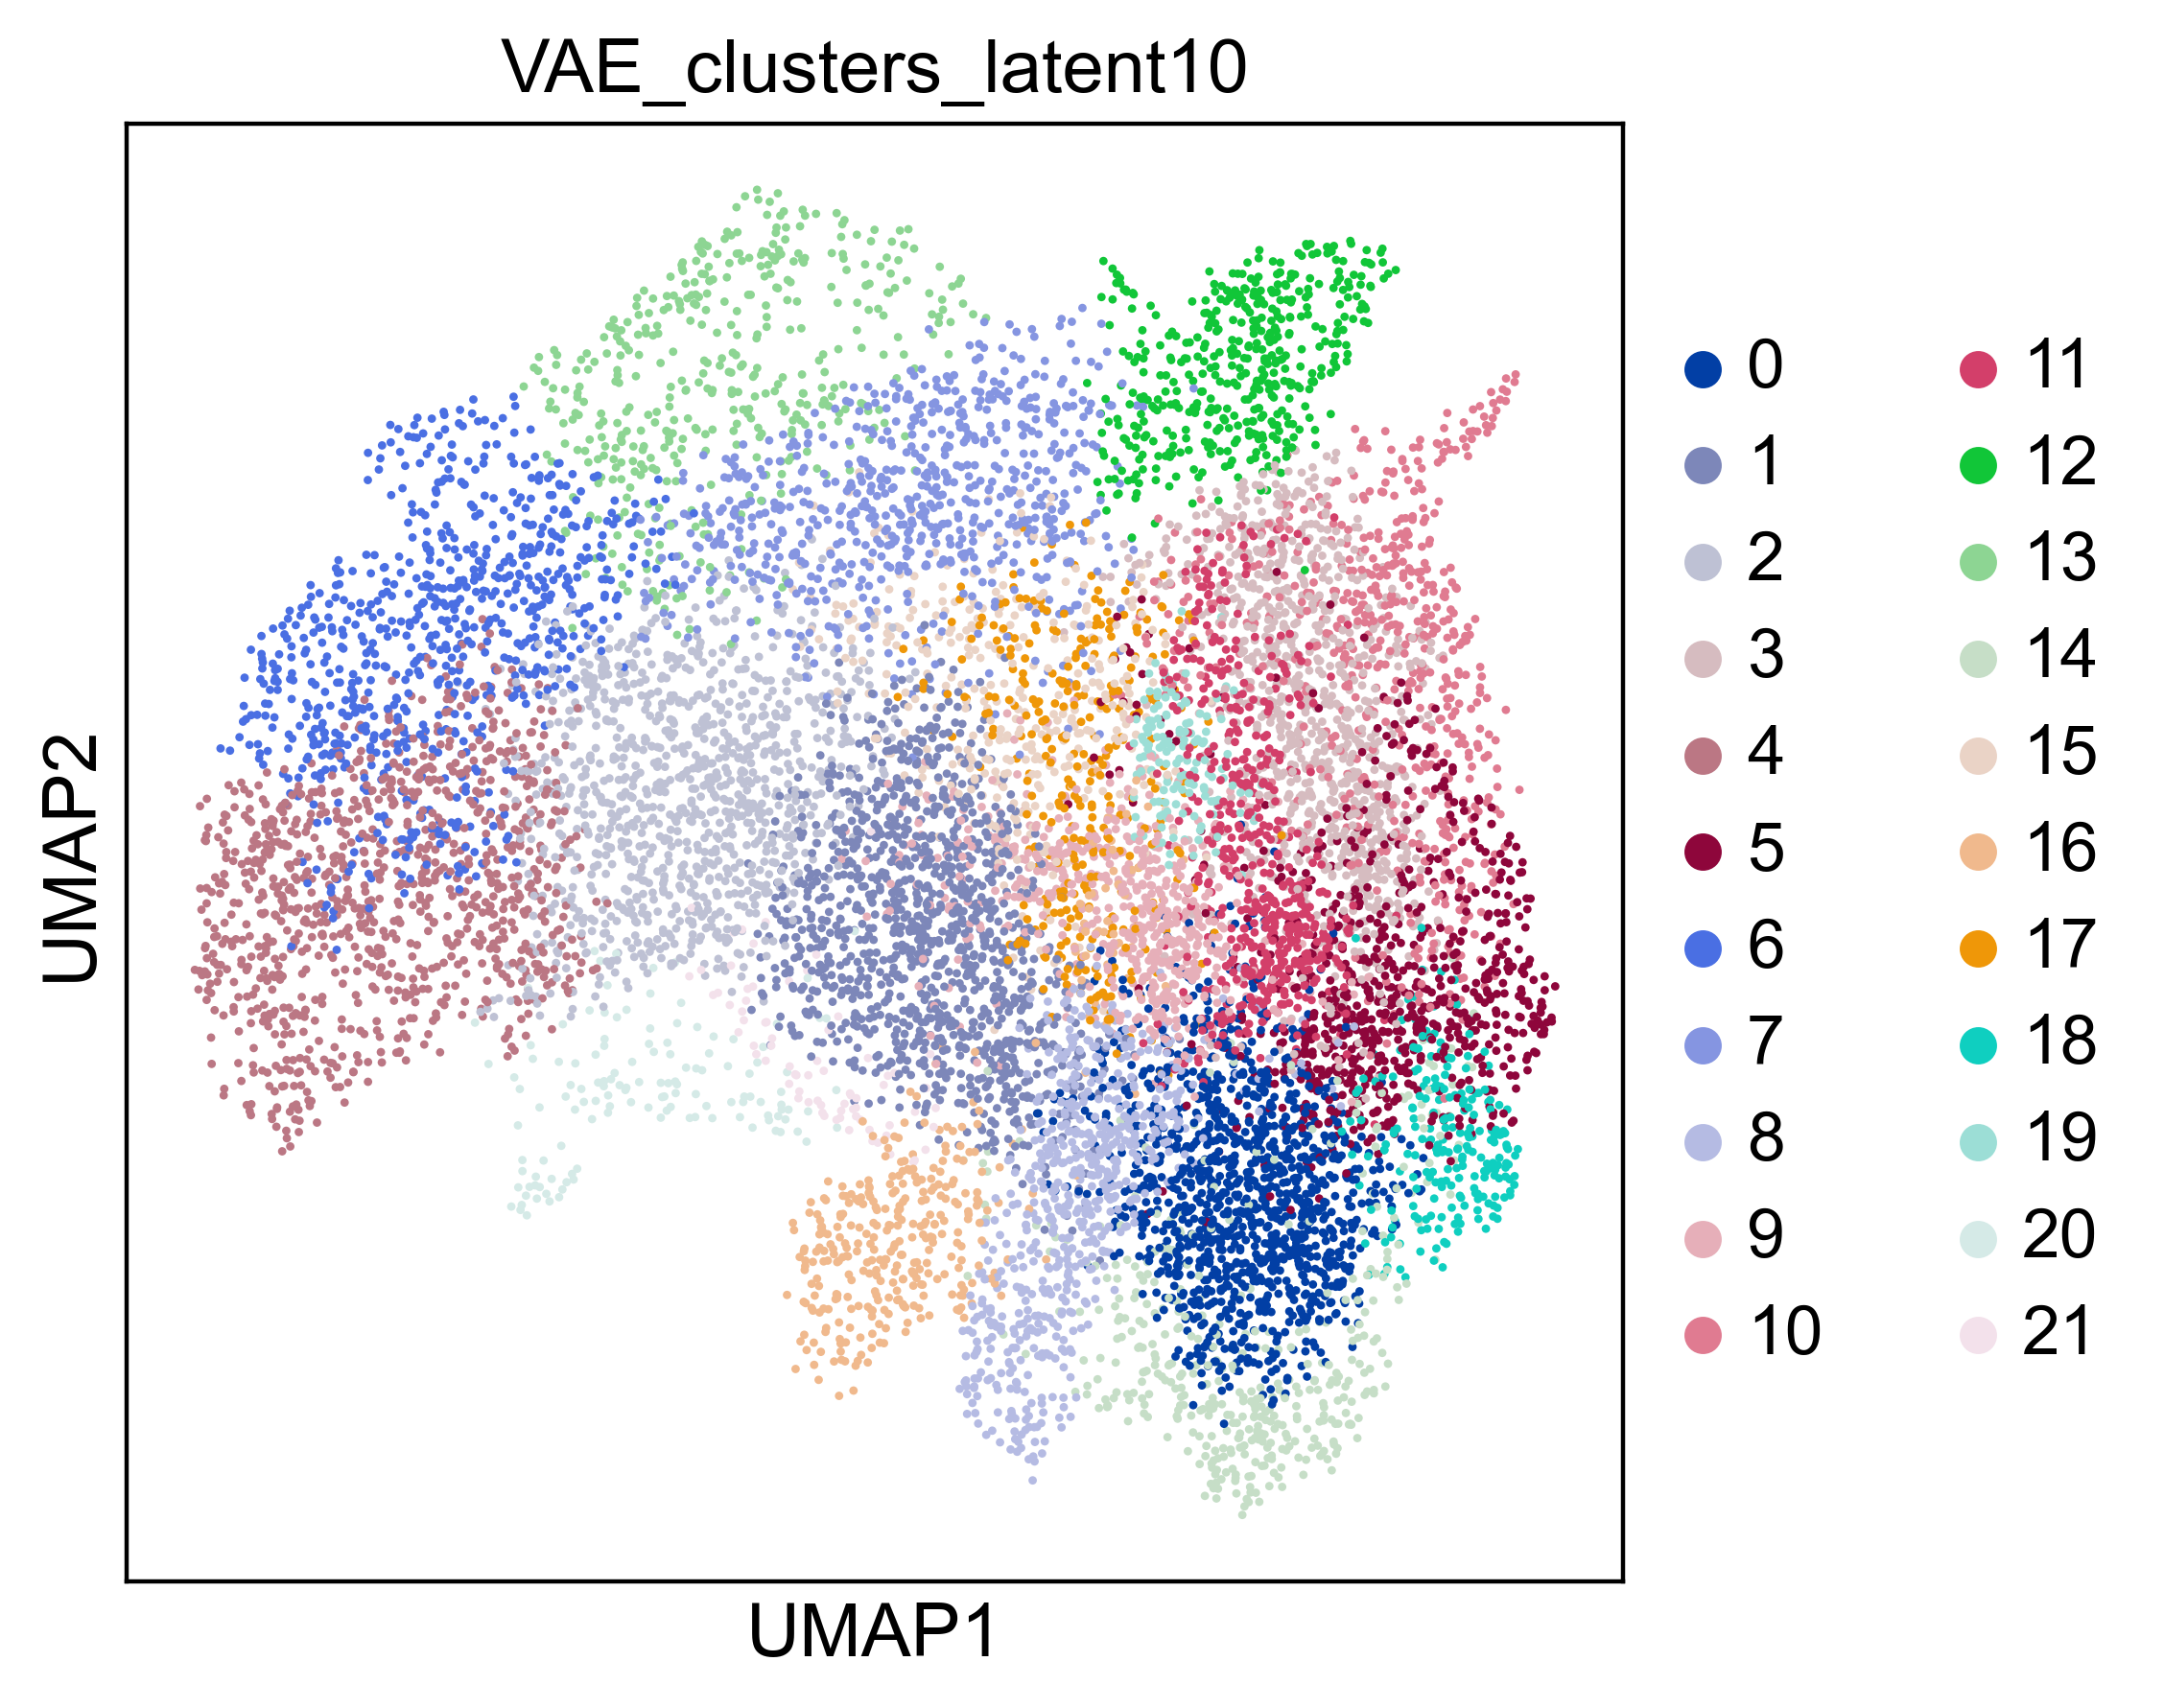

In [41]:
sc.settings.set_figure_params(dpi=200, facecolor="white")
fig,ax=plt.subplots()
fig.set_size_inches(5,5)
sc.pl.umap(merge_adata,
           color=["VAE_clusters_latent10"],
           palette = sc.pl.palettes.default_28,
           show = False,
           size = 10,
           ax=ax
)

In [54]:
merge_adata.write_h5ad("./spatialmeta_tutorial/data/ccRCC_merge_hvf_spatialmeta.h5ad")